In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-pre

# Part I: Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.losses import mean_absolute_percentage_error
import tensorflow as tf
warnings.filterwarnings('ignore')  
%matplotlib inline


In [3]:
dataset_directory = Path('/kaggle/input/amp-parkinsons-disease-progression-prediction')
train_clinical_df = pd.read_csv(dataset_directory / 'train_clinical_data.csv') 
train_peptide_df = pd.read_csv(dataset_directory / 'train_peptides.csv')
train_protein_df = pd.read_csv(dataset_directory / 'train_proteins.csv') 
supp_df = pd.read_csv(dataset_directory / 'supplemental_clinical_data.csv')
supp_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4','upd23b_clinical_state_on_medication'], inplace=True)

In [4]:
# # Analysis of the train_clinical_df
# # for each columns in the train_clinical_df, here are the counts of NaN values.
clinical_df = train_clinical_df.copy()
nan_updrs_1 = clinical_df['updrs_1'].isna().sum() 
nan_updrs_2 = clinical_df['updrs_2'].isna().sum()  
nan_updrs_3 = clinical_df['updrs_3'].isna().sum()   
nan_updrs_4 = clinical_df['updrs_4'].isna().sum()  
nan_medical = clinical_df['upd23b_clinical_state_on_medication'].isna().sum()   
print("Train_Clinical_df: \n(Rows, Columns):", clinical_df.shape,"\nNumber of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: \n", nan_updrs_1,nan_updrs_2, nan_updrs_3, nan_updrs_4, nan_medical)
clinical_df = supp_df.copy()
nan_updrs_1 = clinical_df['updrs_1'].isna().sum() 
nan_updrs_2 = clinical_df['updrs_2'].isna().sum()  
nan_updrs_3 = clinical_df['updrs_3'].isna().sum()   
nan_updrs_4 = clinical_df['updrs_4'].isna().sum()  
nan_medical = clinical_df['upd23b_clinical_state_on_medication'].isna().sum()   
print("\nSupplementary_Clinical_df: \n(Rows, Columns):", clinical_df.shape,"\nNumber of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: \n", nan_updrs_1,nan_updrs_2, nan_updrs_3, nan_updrs_4, nan_medical)


Train_Clinical_df: 
(Rows, Columns): (2615, 8) 
Number of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: 
 1 2 25 1038 1327

Supplementary_Clinical_df: 
(Rows, Columns): (817, 8) 
Number of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: 
 0 0 0 0 0


1. As shown in above, there are 1038/2615 rows in Train_clinical_df have missing values. In order to make use of all the information given in the train_clinical_df, we will use KNN imputation to fill the missing values. 
2. We merge the complete records (no missing values) from Supplementary_clinical_df to Train_clinical_df to augment the clinical dataset aiming to improve the performance of KNN imputation. 
3. Apply x = log (x+1) to transform the data into normal distribution like data. This can also improve the KNN imputation performance. 


## Data cleaning 

1. remove rows with missing values in Supp_df in the specified columns (updrs_1, updrs_2, updrs_3, updrs_4', 'upd23b_clinical_state_on_medication') to keep only the accurate records to augment the train_clinical_df. 


## To analyze the trend in the visit_month column of the DataFrame, we plot a line graph of the average UPDRS scores (i.e., updrs_1, updrs_2, updrs_3, and updrs_4) against the visit_month.

* We can compare the trends of 4 figures using the cleaned dataset, the cleaned dataset filtered by medication "ON", and the cleaned dataset filtered by medication "OFF".

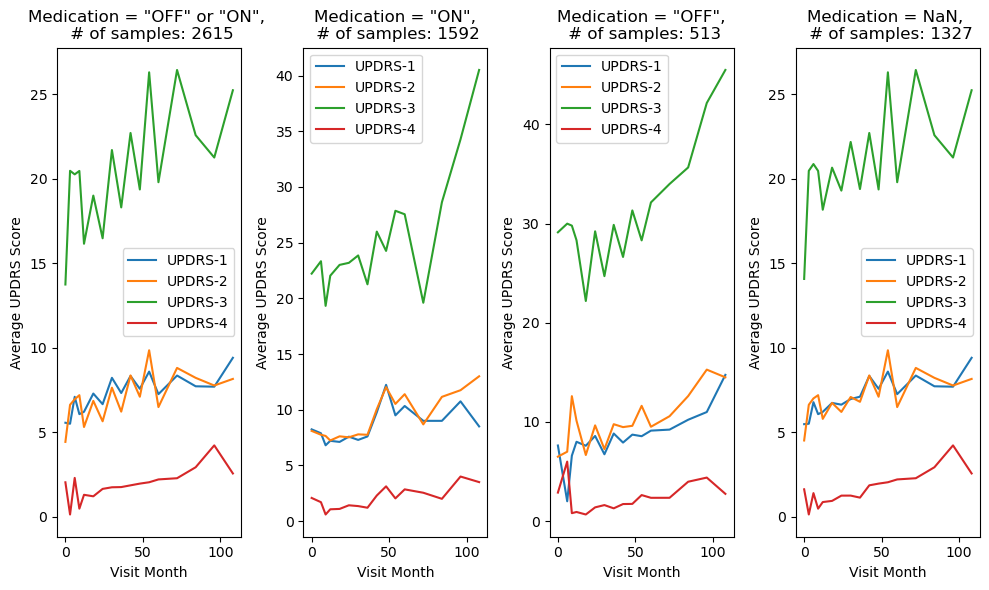

In [5]:
# create three subplots in rows
fig, ax = plt.subplots(ncols = 4,  figsize=(10, 6))

############## the status of "upd23b_clinical_state_on_medication"] is ignored 
# plot the first figure
# read the DataFrame from a file
df = train_clinical_df
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = df.groupby('visit_month').mean()
# plot the line graph of the average UPDRS scores against visit_month
ax[0].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[0].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[0].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[0].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[0].set_xlabel('Visit Month')
ax[0].set_ylabel('Average UPDRS Score')
ax[0].legend()
ax[0].set_title('Medication = "OFF" or "ON", \n # of samples: {}'.format(df.shape[0]))
############## the status of "upd23b_clinical_state_on_medication"] is NaN 
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
nan_medication_df = df[df["upd23b_clinical_state_on_medication"].isna()]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = nan_medication_df.iloc[:, :-1].groupby('visit_month').mean()
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = df.groupby('visit_month').mean()
# plot the line graph of the average UPDRS scores against visit_month
ax[3].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[3].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[3].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[3].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[3].set_xlabel('Visit Month')
ax[3].set_ylabel('Average UPDRS Score')
ax[3].legend()
ax[3].set_title('Medication = NaN, \n # of samples: {}'.format(nan_medication_df.shape[0]))

############## "upd23b_clinical_state_on_medication"] == "On"
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
on_medication_df = df[df["upd23b_clinical_state_on_medication"] == "On"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = on_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[1].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[1].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[1].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[1].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[1].set_xlabel('Visit Month')
ax[1].legend()
ax[1].set_ylabel('Average UPDRS Score')
ax[1].set_title('Medication = "ON",\n # of samples: {}'.format(on_medication_df.shape[0]))


############## "upd23b_clinical_state_on_medication"] == "Off"
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
off_medication_df = df[df["upd23b_clinical_state_on_medication"] == "Off"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = off_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[2].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[2].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[2].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[2].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[2].set_xlabel('Visit Month')
ax[2].set_ylabel('Average UPDRS Score')
ax[2].legend()
ax[2].set_title('Medication = "OFF",\n # of samples: {}'.format(off_medication_df.shape[0]))

# adjust the subplots layout
plt.tight_layout()

# show the plot
plt.show()

In [6]:
# concatenate the two train_clinical_df and supp_df vertically
train_df = pd.concat([train_clinical_df, supp_df], ignore_index=True)

# assume df is your DataFrame
cols_to_normalize = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
# Apply log(1+x) transformation to the last 4 columns
train_df[cols_to_normalize] = np.log1p(train_df[cols_to_normalize])

# perform KNN imputation on the normalized data
imputer = KNNImputer(n_neighbors=10)

on_medication_mask = train_df["upd23b_clinical_state_on_medication"] == "On"
train_df.loc[on_medication_mask, cols_to_normalize] = np.maximum(imputer.fit_transform(train_df.loc[on_medication_mask, cols_to_normalize]), 0)
off_medication_mask = train_df["upd23b_clinical_state_on_medication"] == "Off"
train_df.loc[off_medication_mask, cols_to_normalize] = np.maximum(imputer.fit_transform(train_df.loc[off_medication_mask, cols_to_normalize]), 0)
nan_medication_mask = train_df["upd23b_clinical_state_on_medication"].isna()
train_df.loc[nan_medication_mask, cols_to_normalize] = np.maximum(imputer.fit_transform(train_df.loc[nan_medication_mask, cols_to_normalize]), 0)

train_df[cols_to_normalize]=round(np.maximum(np.expm1(train_df[cols_to_normalize]),0))
train_df = train_df.head(n= 2615)
train_df = train_df.iloc[:, :-1]
train_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0
2612,65043_60,65043,60,6.0,6.0,16.0,1.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0


## Analyze the frequence of visit_month 

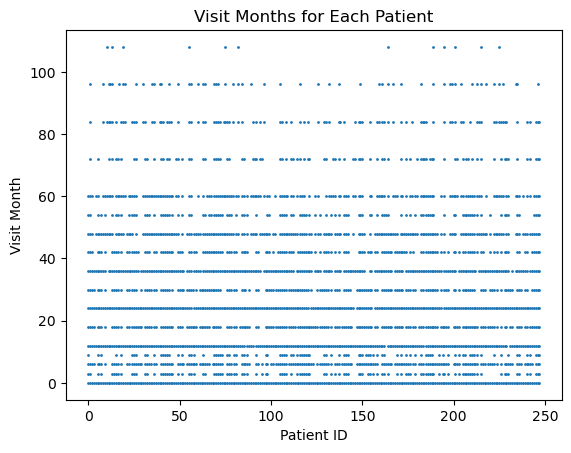

In [7]:
# create a new column with a unique identifier for each patient
df = train_df.copy(deep=True)
df['patient_index'] = df.groupby('patient_id').ngroup()

# create a scatter plot for patient_index versus visit_month
plt.scatter(df['patient_index'], df['visit_month'], s=1)

#plt.scatter(df_new_index.index, df_new_index["visit_month"], s=1)
plt.xlabel("Patient ID")
plt.ylabel("Visit Month")
plt.title("Visit Months for Each Patient")

# display the plot
plt.show()

* In the figure above, the interval between visit_month is approximately 6 months until the 60th month, after which the data becomes sparse. This suggests that only a few patient_id have long-term records beyond 60 months. Therefore, we will focus only on the data from the 60 months prior to the current time period. 
* Since the target of the prediction is from the current time point to 6, 6, 12 months, it would be helpful to include data up to 72 months to gather as much information as possible in our training dataset.

In [8]:
# Part II. Construct time series data

In [9]:
train_df = train_df.rename(columns={
    'updrs_1': 'updrs_1_plus_0_months',
    'updrs_2': 'updrs_2_plus_0_months',
    'updrs_3': 'updrs_3_plus_0_months',
    'updrs_4': 'updrs_4_plus_0_months'
})
train_df

,visit_id,patient_id,visit_month,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0
2612,65043_60,65043,60,6.0,6.0,16.0,1.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0


In [10]:
# define an empty DataFrame with column names
ts_df_updrs = pd.DataFrame(columns=['time', 'patient_id',  'visit_id',
                                    'updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                                    'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                                    'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                                    'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months'
                                    ])

for patient_id in train_df['patient_id'].unique():
    # filter a subset of visiting records for a selected patient_id 
    p_df = train_df[train_df['patient_id']==patient_id]
    ts_start = p_df.visit_month.min()
    ts_end = p_df.visit_month.max()
    ts_span = ts_end - ts_start
    p_num = p_df.shape[0]
    if (p_num > 1) and (ts_span >= 30) and (ts_span/(p_df.shape[0]-1) < 24):
        # the last visit record is 72
        if ts_end > 72:
            ts_end = 72+1

        patient_df = pd.DataFrame({'time': range(ts_start, ts_end, 6), 'patient_id': patient_id})
        # Add the visit_id column
        patient_df['visit_id'] = patient_df['patient_id'].astype(str) + '_' + patient_df['time'].astype(str)
        # merge dataframes on visit_id using left join
        merged_df = pd.merge(patient_df, p_df, on='visit_id', how='left')
        merged_df.drop('patient_id_y', axis=1,inplace = True)
        merged_df.rename(columns={'patient_id_x': 'patient_id'},inplace = True)
        # forward fill missing values
        merged_df = merged_df.fillna(method='ffill')
        # generate new columns updrs_p6_1, updrs_p6_2, updrs_p6_3, updrs_p6_4
        merged_df['updrs_1_plus_6_months'] = merged_df['updrs_1_plus_0_months'].shift(-1)
        merged_df['updrs_2_plus_6_months'] = merged_df['updrs_2_plus_0_months'].shift(-1)
        merged_df['updrs_3_plus_6_months'] = merged_df['updrs_3_plus_0_months'].shift(-1)
        merged_df['updrs_4_plus_6_months'] = merged_df['updrs_4_plus_0_months'].shift(-1)
        merged_df['updrs_1_plus_12_months'] = merged_df['updrs_1_plus_0_months'].shift(-2)
        merged_df['updrs_2_plus_12_months'] = merged_df['updrs_2_plus_0_months'].shift(-2)
        merged_df['updrs_3_plus_12_months'] = merged_df['updrs_3_plus_0_months'].shift(-2)
        merged_df['updrs_4_plus_12_months'] = merged_df['updrs_4_plus_0_months'].shift(-2)
        merged_df['updrs_1_plus_24_months'] = merged_df['updrs_1_plus_0_months'].shift(-4)
        merged_df['updrs_2_plus_24_months'] = merged_df['updrs_2_plus_0_months'].shift(-4)
        merged_df['updrs_3_plus_24_months'] = merged_df['updrs_3_plus_0_months'].shift(-4)
        merged_df['updrs_4_plus_24_months'] = merged_df['updrs_4_plus_0_months'].shift(-4)
    
        merged_df = merged_df.drop('visit_month', axis=1)
        merged_df = merged_df.dropna()
        ts_df_updrs= pd.concat([ts_df_updrs, merged_df],ignore_index=True)
        
        


In [11]:
 ts_df_updrs

,time,patient_id,visit_id,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months,updrs_1_plus_6_months,updrs_2_plus_6_months,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,0,55,55_0,10.0,6.0,15.0,0.0,8.0,10.0,34.0,0.0,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,6,55,55_6,8.0,10.0,34.0,0.0,10.0,10.0,41.0,0.0,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,12,55,55_12,10.0,10.0,41.0,0.0,7.0,13.0,38.0,0.0,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,18,55,55_18,7.0,13.0,38.0,0.0,16.0,9.0,49.0,0.0,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,24,55,55_24,16.0,9.0,49.0,0.0,14.0,13.0,49.0,0.0,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,24,65043,65043_24,4.0,8.0,23.0,0.0,3.0,4.0,4.0,0.0,2.0,7.0,5.0,0.0,7.0,6.0,13.0,0.0
1599,30,65043,65043_30,3.0,4.0,4.0,0.0,2.0,7.0,5.0,0.0,9.0,10.0,15.0,0.0,4.0,8.0,11.0,1.0
1600,36,65043,65043_36,2.0,7.0,5.0,0.0,9.0,10.0,15.0,0.0,7.0,6.0,13.0,0.0,6.0,6.0,16.0,1.0
1601,42,65043,65043_42,9.0,10.0,15.0,0.0,7.0,6.0,13.0,0.0,4.0,8.0,11.0,1.0,6.0,6.0,16.0,1.0


# Part II: Extract features from Proteins and Peptides

## Join Protein and Peptide on 'visit_id' and 'UniProt'

In [12]:
Prot_Peptides_df = pd.merge(train_protein_df, train_peptide_df, on = ['visit_id','UniProt'], how = 'left')
Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','NPX','Peptide','PeptideAbundance']]
Prot_Peptides_df

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,O00391,11254.3,NEQEQPLGQWHLS,11254.30
1,55_0,O00533,732430.0,GNPEPTFSWTK,102060.00
2,55_0,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00
3,55_0,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,O00533,732430.0,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...
981829,58648_108,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00
981830,58648_108,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00
981831,58648_108,Q9Y646,21257.6,LALLVDTVGPR,21257.60
981832,58648_108,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


* check are there NaN values in Prot_Peptides_df

In [13]:
Prot_Peptides_df.isna().sum().sum()

0

* As shown above, there is no Nan in Prot_Peptides_df

## Select a subset of UniProt, which are shared in all visit_id samples

In [14]:
# group by visit_id and get the set of unique UniProt values for each group
grouped = Prot_Peptides_df.groupby('visit_id')['UniProt'].apply(set)

# calculate the intersection of UniProt values across all groups
intersection = set.intersection(*grouped)

# print the intersection
print(intersection, len(intersection))

{'P01011', 'P23142', 'P10909', 'P01042', 'Q12805', 'P02774', 'P06396', 'P01834', 'P02768', 'P02751', 'P41222', 'P01024', 'P01009', 'P01876', 'P02749', 'P02765', 'P02787', 'O15240', 'P02647', 'P02766', 'P05090', 'Q9UHG2', 'P01023', 'Q92520', 'P02790', 'P02649', 'P07602'} 27


* Among all samples, there are 27 UniProt entries that are present.
* Select the 27 UniProt as features and filter the Prot_Peptides_df to have the intersection. 

In [15]:
# set of UniProt values to select
uniprots_to_select = intersection

# filter the dataframe to select rows with UniProt values in the set
df_filtered = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]
# print the resulting dataframe
print(df_filtered)



         visit_id UniProt         NPX          Peptide  PeptideAbundance
15           55_0  O15240    177775.0      AYQGVAAPFPK         107076.00
16           55_0  O15240    177775.0     QQETAAAETETR           3095.35
17           55_0  O15240    177775.0     THLGEALAPLSK          67603.70
94           55_0  P01009  14415900.0          FLENEDR          41501.10
95           55_0  P01009  14415900.0         FLENEDRR          46973.10
...           ...     ...         ...              ...               ...
981797  58648_108  Q92520    907400.0         SPFEQHIK          66357.20
981826  58648_108  Q9UHG2    369437.0     AEAQEAEDQQAR           7884.17
981827  58648_108  Q9UHG2    369437.0   ARAEAQEAEDQQAR          80542.00
981828  58648_108  Q9UHG2    369437.0     GEAAGAVQELAR          78191.40
981829  58648_108  Q9UHG2    369437.0  ILAGSADSEGVAAPR         202820.00

[424373 rows x 5 columns]


## Data preprocessing for 'PeptideAbundance'
* Since the 'PeptideAbundance' column contains large integer features, we apply a logarithmic transformation (log(x+1)) to approximate normality and stabilize their variance. This transformation is commonly used to address skewness in data with a wide range of values. By applying this transformation, the values in these columns are shifted towards zero, resulting in a more symmetric distribution that is characteristic of normal distribution.

* To ensure the transformed values have similar scales, we standardize the data using Z-score normalization on the log-transformed values of the original feature. This step ensures that each feature contributes equally to the analysis, regardless of their original scales.

* Overall, applying log(x+1) to 'PeptideAbundance' columns and rescaling using Z-score normalization can improve the accuracy and reliability of subsequent analyses.


In [16]:
# apply log(x+1) transformation to columns
df_filtered[['PeptideAbundance']] = df_filtered[['PeptideAbundance']].apply(lambda x: np.log1p(x))

# standardization
scaler1 = StandardScaler()
df_filtered[['PeptideAbundance']] = scaler1.fit_transform(df_filtered[['PeptideAbundance']])


In [17]:
# create a list of all peptides presented in the original data
all_peptides = df_filtered['Peptide'].unique()
# create a list of all visit_id in the original data
all_visit_id = df_filtered['visit_id'].unique()

# Protein-peptide network analysis
Protein-peptide network analysis is a powerful tool for understanding the interactions between proteins and peptides in biological systems. It involves the creation of a network graph, where nodes represent proteins and peptides and edges represent their interactions or relationships.
In this project, we can create a network graph where each protein and peptide is represented as a node and their interactions are represented as edges. The weight of the edges are the PeptideAbundance. 
# Take one 'visit_id' for example to show how to construct a Protein-peptide Network.
1. Construct a Prop-Peptide Network for the visit_id
2. Protein-Peptide Network Visulization

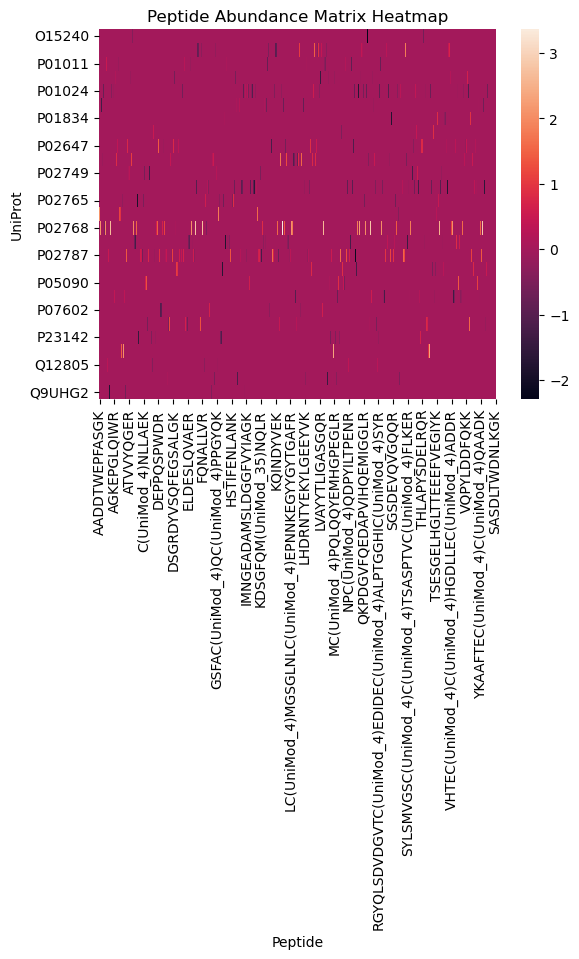

In [18]:
visit_id ='55_12'
p_df = df_filtered[df_filtered['visit_id'] == visit_id]
# first, pivot the data so that the UniProt column becomes the index, 
# the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
# iterate over each UniProt and add missing peptides as columns with a value of 0
for prot in pivoted.index:
    missing_peptides = set(all_peptides) - set(pivoted.columns)
    for pep in missing_peptides:
        pivoted.loc[prot, pep] = 0

# fill any remaining missing values with 0
pivoted.fillna(0, inplace=True)

# Plot the heatmap
sns.heatmap(pivoted)
# Set the title of the heatmap
plt.title("Peptide Abundance Matrix Heatmap")

# Show the heatmap
plt.show()

# Feature extractoin of UniProt-Peptides Network
## Principal component analysis (PCA) is used to extract the most important components of the Protein-Peptides network. These components could then be used as features for downstream analysis

# Average Protein-Peptides Networks among all visit_id

In [19]:
pca = PCA(n_components = 10)

# initialize an empty list to store the PCA features
pca_features_list = []

for visit_id in all_visit_id:
    # Part 1: construct UniProt-Peptide Network for each visit_id
    p_df = df_filtered[df_filtered['visit_id'] == visit_id]
    # first, pivot the data so that the UniProt column becomes the index, 
    # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
    pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
    # iterate over each UniProt and add missing peptides as columns with a value of 0
    for prot in pivoted.index:
        missing_peptides = set(all_peptides) - set(pivoted.columns)
        for pep in missing_peptides:
            pivoted.loc[prot, pep] = 0

    # fill any remaining missing values with 0
    pivoted.fillna(0, inplace=True)
    
    # Part II: Sum up all networks of all visit_id 
    if visit_id == all_visit_id[0]:
        avg_network = pivoted
    else:
        avg_network = avg_network.add(pivoted, fill_value=0)
    
    # Part III: PCA feature extraction
    # reset the index so that UniProt is a column again
    pivoted = pivoted.reset_index()
    # rename the index column to 'UniProt'
    pivoted.index.name = 'UniProt'
    # save the pivoted DataFrame to a new variable called `new_df`
    new_df = pivoted.copy(deep=True)
    # fit and transform the data
    df1_pca = pca.fit_transform(new_df.iloc[:,1:])
    # flatten the array to one dimension
    df1_pca = np.array(df1_pca).flatten()
    # store the PCA features along with the visit_id in the list
    pca_features_list.append({'visit_id': visit_id, 'pca_features': df1_pca})
    
# calculate the average network 
avg_network = avg_network / len(all_visit_id)
# construct a dataframe from the PCA features list
df_pca_features = pd.DataFrame(pca_features_list)
# split the pca_features column into multiple columns
PP_features = pd.concat([df_pca_features.drop('pca_features', axis=1), df_pca_features['pca_features'].apply(pd.Series)], axis=1)

# display the resulting dataframe
print(PP_features)


       visit_id         0         1         2         3         4         5  \
0          55_0 -0.408761 -0.191259 -0.143086 -0.097637 -0.121823 -0.008657   
1        1517_0 -0.390323 -0.207683 -0.223584 -0.037062 -0.226242 -0.162619   
2        1923_0 -0.375939 -0.189745 -0.240332 -0.183197 -0.170522 -0.098476   
3        2660_0 -0.348659 -0.177171 -0.200724 -0.074223 -0.092662 -0.088853   
4        3636_0 -0.366450 -0.188364 -0.165799 -0.269625 -0.250694 -0.115397   
...         ...       ...       ...       ...       ...       ...       ...   
1108   58648_96 -0.375338 -0.090774 -0.171280 -0.221629 -0.094996 -0.008812   
1109   5645_108 -0.420115 -0.094926 -0.274239 -0.107466 -0.152648 -0.184514   
1110  12703_108 -0.335764 -0.160216 -0.159047 -0.013911 -0.230621 -0.141327   
1111  55096_108 -0.414612 -0.076189 -0.264506 -0.266721 -0.201371 -0.251426   
1112  58648_108 -0.371630 -0.114047 -0.246301 -0.108698 -0.044771 -0.252302   

             6         7         8  ...       260  

## Average Protein-Peptides Network Visulization

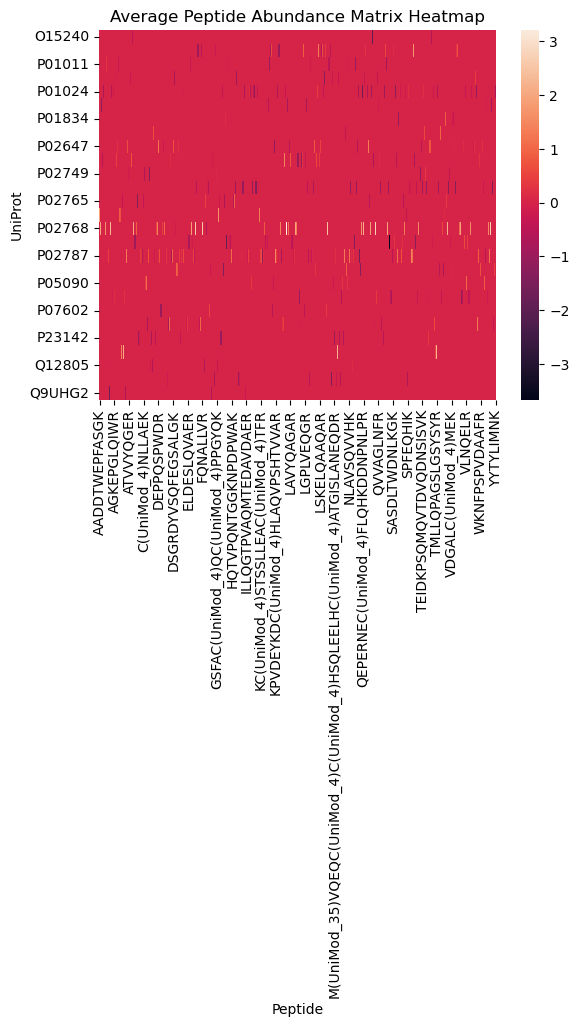

In [20]:
# Plot the heatmap
sns.heatmap(avg_network)
# Set the title of the heatmap
plt.title("Average Peptide Abundance Matrix Heatmap")
# Show the heatmap
plt.show()

## To create a training DataFrame for a deep learning model, we join the PP_features and ts_df_updrs DataFrames, and then remove any rows with NaN values.

# Part III: Deep learning model

In [21]:

PP_features1 = PP_features.merge(ts_df_updrs, on='visit_id')

target_list = ['updrs_1_plus_0_months', 'updrs_2_plus_0_months',
       'updrs_3_plus_0_months', 'updrs_4_plus_0_months',
       'updrs_1_plus_6_months', 'updrs_2_plus_6_months',
       'updrs_3_plus_6_months', 'updrs_4_plus_6_months',
       'updrs_1_plus_12_months', 'updrs_2_plus_12_months',
       'updrs_3_plus_12_months', 'updrs_4_plus_12_months',
       'updrs_1_plus_24_months', 'updrs_2_plus_24_months',
       'updrs_3_plus_24_months', 'updrs_4_plus_24_months']
info_list =['visit_id','time', 'patient_id']
cols_to_scale = PP_features1.columns.difference(target_list+info_list)

#train_fea_target.columns[:-16]
train_fea_target = PP_features1.copy(deep=True)
# perform z-score normalization on the training data
scaler_features = StandardScaler()
# fit and transform the data
scaler_features.fit(train_fea_target[cols_to_scale])
#train_fea_target[cols_to_scale] = scaler.transform(train_fea_target[cols_to_scale])
train_fea_target[cols_to_scale] = scaler_features.transform(train_fea_target[cols_to_scale])

# Define the ratios for train, validation, and test sets
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.10

# Get a list of unique patient IDs in the DataFrame
patient_ids = train_fea_target['patient_id'].unique()

# Shuffle the list of patient IDs
np.random.shuffle(patient_ids)

# Calculate the number of patients for each set
num_patients = len(patient_ids)
num_train_patients = int(num_patients * train_ratio)
num_val_patients = int(num_patients * val_ratio)
num_test_patients = num_patients - num_train_patients - num_val_patients

# Split the patient IDs into train, validation, and test sets
train_patients = patient_ids[:num_train_patients]
val_patients = patient_ids[num_train_patients:num_train_patients+num_val_patients]
test_patients = patient_ids[num_train_patients+num_val_patients:]

# Create train, validation, and test DataFrames using the patient ID splits
train_df = train_fea_target[train_fea_target['patient_id'].isin(train_patients)].drop(columns= ['visit_id','time', 'patient_id'])
val_df = train_fea_target[train_fea_target['patient_id'].isin(val_patients)].drop(columns= ['visit_id','time', 'patient_id'])
test_df = train_fea_target[train_fea_target['patient_id'].isin(test_patients)].drop(columns= ['visit_id','time', 'patient_id'])

# Print the number of rows in each set
print(f'Training set: {len(train_df)} rows')
print(f'Validation set: {len(val_df)} rows')
print(f'Testing set: {len(test_df)} rows')

Training set: 617 rows
Validation set: 33 rows
Testing set: 76 rows


In [22]:
from tensorflow.keras.optimizers import Adam
X_train = train_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_train = train_df.iloc[:, -16:].astype(int)   # select only the last 16 columns
X_val = val_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_val = val_df.iloc[:, -16:].astype(int)   # select only the last 16 columns
X_test = test_df.iloc[:, :-16].astype(float)   # select all columns except the last 16
y_test = test_df.iloc[:, -16:].astype(int)  # select only the last 16 columns


In [23]:
def smape_loss(y_true, y_pred):
    y_true = K.cast(y_true,dtype='float32') + 1
    y_pred = y_pred + 1
    numer = K.abs(y_pred - y_true)
    denom = K.abs(y_true) + K.abs(y_pred) 
    smape = 100 * numer / denom
    return smape


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    y_true -- array of true values
    y_pred -- array of predicted values
    
    """

    y_true = y_true +1
    y_pred = y_pred +1
    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_pred) + np.abs(y_true) 
    
    smape = 100 * np.mean(numerator / denominator)
    return smape


29.269765853881836


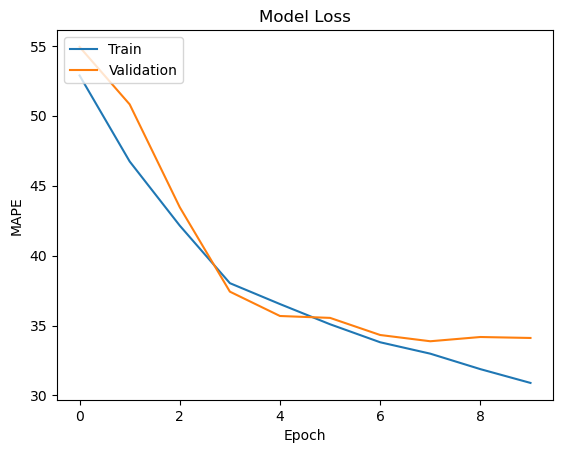

28.951988220214844


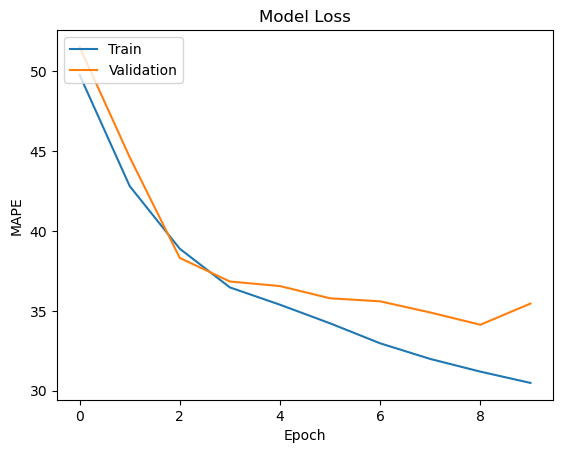

27.791223526000977


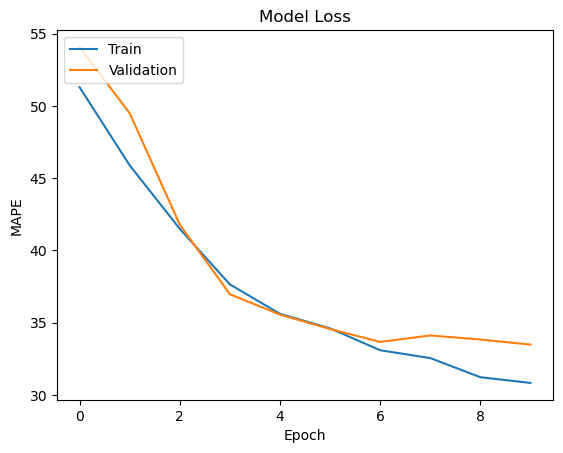

29.462661743164062


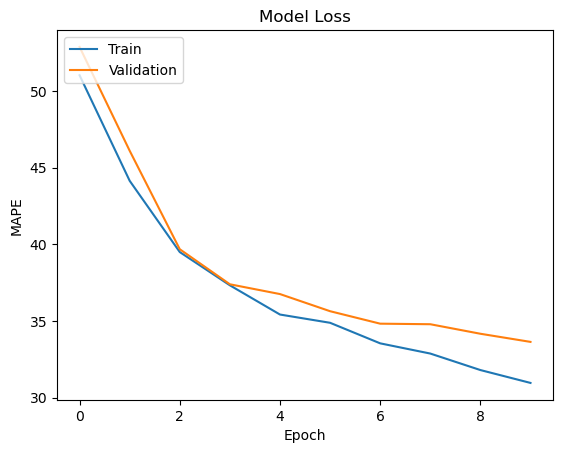

28.40373420715332


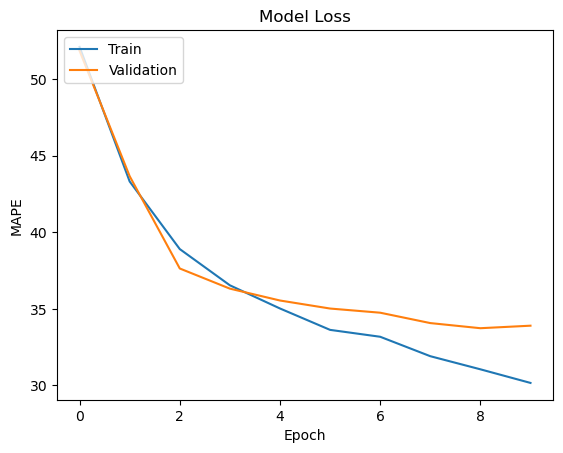

In [24]:
# Initialize variables to store the best model and its test score

best_model = None
best_test_score = float('inf')  # Set to infinity initially

for _ in range(5):
    # Create a new model for each iteration
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(16, activation='linear'))

    # Create Adam optimizer with a learning rate of 0.001
    adam = Adam(learning_rate=0.0001)

    # Compile model with Adam optimizer and a learning rate of 0.0001
    model.compile(loss=smape_loss, optimizer='adam')
    
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=0, batch_size=32)
    
    # Evaluate the model on the test set
    test_score = model.evaluate(X_test, y_test, verbose=0)
    
    # Check if the current model has a better test score than the previous best model
    if test_score < best_test_score:
        best_model = model
        best_test_score = test_score
    
    print(test_score)
    # Plot training and validation loss over epochs for each iteration
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Use the best model for predictions
model = best_model


In [25]:
print(best_test_score)

27.791223526000977


# Part IV: Submission 

Here, we create a new empty DataFrame new_df with the same structure as avg_network. We then fill in the values of new_df with values from df_filtered2 if available, and avg_network otherwise, using nested loops over the proteins and peptides. If a protein or peptide is not present in df_filtered2, we use the corresponding row or column from avg_network. Finally, we fill in any remaining missing values with 0.

The script iterates over the test data, applies preprocessing steps, including data filtering, scaling, and dimensionality reduction using PCA. The reduced features are then passed to the pre-trained model for prediction.

In [26]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files


In [27]:

# Create a new DataFrame
hist_df = pd.DataFrame(columns = ['patient_id']+ target_list)

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    # Convert patient_id in test DataFrame to string
    test['patient_id'] = test['patient_id'].astype(str)
    
    Prot_Peptides_df2 = pd.merge(test_proteins, test_peptides, on = ['visit_id','UniProt'], how = 'left')
    Prot_Peptides_df2 = Prot_Peptides_df2[['visit_id','UniProt','Peptide','PeptideAbundance']]
    df_filtered2 = Prot_Peptides_df2[Prot_Peptides_df2['UniProt'].isin(list(avg_network.index))]
    
    # apply log(x+1) transformation to columns
    df_filtered2[['PeptideAbundance']] = df_filtered2[['PeptideAbundance']].apply(lambda x: np.log1p(x))
    # standardization
    df_filtered2[['PeptideAbundance']] = scaler1.fit_transform(df_filtered2[['PeptideAbundance']])

    pca_features_list2 = []

    for visit_id in df_filtered2['visit_id'].unique():
        # Part 1: construct UniProt-Peptide Network for each visit_id
        p_df = df_filtered2[df_filtered2['visit_id'] == visit_id]
        # Create a new empty DataFrame using the structure of avg_network
        new_df = pd.DataFrame(index=avg_network.index, columns=avg_network.columns)
        # Fill in the new DataFrame with values from df_filtered2 or avg_network
        for prot in avg_network.index:
            if prot in p_df['UniProt'].values:
                for peptide in avg_network.columns:
                    if peptide in p_df[p_df['UniProt'] == prot]['Peptide'].values:
                        new_df.loc[prot, peptide] = p_df[(p_df['UniProt'] == prot) & (p_df['Peptide'] == peptide)]['PeptideAbundance'].values[0]
                    else:
                        new_df.loc[prot, peptide] = 0 #avg_network.loc[prot, peptide]
            else:
                new_df.loc[prot, :] = avg_network.loc[prot, :]

        # Fill any remaining missing values with 0
        new_df.fillna(0, inplace=True)
        
        # Part II: PCA feature extraction
        # fit and transform the data
        df1_pca = pca.fit_transform(new_df) #.iloc[:,1:])
        # flatten the array to one dimension
        df1_pca = np.array(df1_pca).flatten()
        # store the PCA features along with the visit_id in the list
        pca_features_list2.append({'visit_id': visit_id, 'pca_features': df1_pca})

    # construct a dataframe from the PCA features list
    df_pca_features2 = pd.DataFrame(pca_features_list2)
    # split the pca_features column into multiple columns
    PP_features2 = pd.concat([df_pca_features2.drop('pca_features', axis=1), df_pca_features2['pca_features'].apply(pd.Series)], axis=1)
    
    col_fea=PP_features2.columns[1:]
    X_test_sub = scaler_features.transform(PP_features2[col_fea])
    # model.predict(tf.convert_to_tensor(X_test_sub)).astype(int)

    test_result = np.maximum(model.predict(tf.convert_to_tensor(X_test_sub)),0) 
    # Create a new DataFrame with the visit_id and predicted target variables
    result_df = pd.DataFrame({'visit_id': PP_features2['visit_id']})
    for i in range(16):
        result_df[target_list[i]]=test_result[:,i]
            
    # Create a new DataFrame to store the predictions
    predictions = pd.DataFrame()
    # Generate a prediction_id for each combination of visit_id and column name
    for col in result_df.columns[1:]:
        predictions = predictions.append(result_df[['visit_id', col]].rename(columns={col: 'rating'}).assign(prediction_id=lambda x: x['visit_id'] + '_' + col))
        
    for i, row in predictions.iterrows():
        prediction_id = row['prediction_id']
        rating = row['rating']
        sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = np.round(rating).astype(int)
    
    #####
    # Add the new rows to the DataFrame
    result_df['patient_id'] = result_df['visit_id'].str.split('_').str[0]
    result_df = result_df.drop('visit_id', axis=1)

    # Check if patient_id exists in hist_df
    existing_ids = hist_df['patient_id'].unique()
    new_ids = result_df[~result_df['patient_id'].isin(existing_ids)]

    if not new_ids.empty:
        hist_df = pd.concat([hist_df, new_ids], ignore_index=True)
    else:
        for idx, row in result_df.iterrows():
            pid = row['patient_id']
            hist_df.loc[hist_df['patient_id'] == pid, result_df.columns] = row.values
        
    # For the 'patient_id' values that exist in the DataFrame 'test' but not in the DataFrame 'test_proteins'.
    patient_id_difference = set(test['patient_id'].unique()) - set(test_proteins['patient_id'].unique())
    for patient_id in patient_id_difference:
        if patient_id in hist_df['patient_id'].unique():
            prediction_pat_id = patient_id +'_' + str(test.loc[test['patient_id']== patient_id,'visit_month'].values[-1])
            for i in range(16):
                prediction_id = prediction_pat_id  + '_' +target_list[i]
                rating = hist_df.loc[hist_df['patient_id'] == patient_id].iloc[0, i+1]
                sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = int(rating)
        
        else:
            # Create a dictionary with the values for the new row
            new_row = {
                'patient_id': patient_id,
                'updrs_1_plus_0_months': 5,
                'updrs_2_plus_0_months': 5,
                'updrs_3_plus_0_months': 17,
                'updrs_4_plus_0_months': 0,
                'updrs_1_plus_6_months': 6,
                'updrs_2_plus_6_months': 6,
                'updrs_3_plus_6_months': 17,
                'updrs_4_plus_6_months': 0,
                'updrs_1_plus_12_months': 6,
                'updrs_2_plus_12_months': 6,
                'updrs_3_plus_12_months': 17,
                'updrs_4_plus_12_months': 0,
                'updrs_1_plus_24_months': 7,
                'updrs_2_plus_24_months': 6,
                'updrs_3_plus_24_months': 18,
                'updrs_4_plus_24_months': 0
            }
            # Add the new row to the DataFrame
            hist_df = hist_df.append(new_row, ignore_index=True)
            prediction_pat_id = patient_id +'_' + str(test.loc[test['patient_id']== patient_id,'visit_month'].values[-1])
            for i in range(16):
                prediction_id = prediction_pat_id + '_' + target_list[i]
                rating = hist_df.loc[hist_df['patient_id'] == patient_id].iloc[0, i+1]
                sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = int(rating)


    env.predict(sample_submission[['prediction_id', 'rating']])   # register your predictions


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 30ms/step
